# Feature Selection

In [1]:
%matplotlib notebook

In [2]:
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
import multiprocessing

In [3]:
### Realizamos el cambio de directoroi de trabajo al "Directorio Base" que se
current_dir = os.getcwd()
base_path = os.path.dirname(current_dir)

os.chdir(base_path)

In [4]:
import scripts.auxiliares.GA as GA
import scripts.funciones as funciones

C:\Users\pasal\Anaconda3\envs\PI2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Carga y Preparación de Datos

In [6]:
d_ini = dt.datetime(2017,6,1)
#d_fin = dt.datetime(2019,8,1) 
d_fin = dt.datetime(2017,7,1) 

In [7]:
%%time

version = 'verFinal'

### params
freq1 = '1D'
freq2 = '3D'
freq3 = '7D'
freq4 = '14D'
freq5 = '30D'
freq6 = '60D'
n_proc = multiprocessing.cpu_count() -1

### Realizamos la lectura de la informacion climatica en el rango de fechas
### especificado, incluye la etiqueta de si ocurre o no un accidente. 
### Posteriormente, en la organizacion de la informacion climatica, lo
### que se hace es agregar las variables con la informacion distribucional
### de las ultimas 5 horas de la info climatica
data = funciones.read_clima_accidentes(d_ini, d_fin, poblado = True)
data_org = funciones.organizar_data_infoClima(data)


### agregamos la informacion relacionada a la cantidad de accidentes ocurridas
### en las ultimas X horas
### Agregar senales
senales = [freq1, freq2, freq3, freq4, freq5, freq6]
d_ini_acc = d_ini - dt.timedelta(days = int(freq6.replace('D', '')))  ### freq mayor
raw_accidentes = funciones.read_accidentes(d_ini_acc, d_fin)
for fresen in senales:
    data_org = funciones.obtener_accidentes_acumulados(data_org, 
                                                        raw_accidentes, 
                                                        freq = fresen)


### Convertimos la bariable de Barrios en variable dummy para ser incluida
### en el modelo
data_org['poblado'] = data_org['BARRIO']
data_org= pd.get_dummies(data_org, columns=['poblado'])

### Relizamos la particion del conjunto de datos en las variables
### explicativas (X) y la variable respuesta (Y)
X = data_org.drop(columns = ['TW','BARRIO','Accidente','summary'])
Y = data_org['Accidente']       

Wall time: 12.4 s


In [8]:
### Dividimos el conjunto de datos en entrenamiento y validacion
X_train, X_val, Y_train, Y_val = train_test_split(X, 
                                                  Y,
                                                  stratify = Y,
                                                  test_size = 0.2,
                                                  random_state = 42)

train_indices = X_train.index.values
val_indices = X_val.index.values

In [9]:
%%time
### Realizamos resampling combinando Tomek Links y Random Undersampling

### Tomek Link
tomeklinks = TomekLinks()
X_tom, y_tom = tomeklinks.fit_sample(X_train, Y_train)

### Random Undersampling
rus = RandomUnderSampler(sampling_strategy = 30/70,random_state = 42)
X_train_under, Y_train_under = rus.fit_sample(X_train, Y_train)

Wall time: 5.92 s


In [10]:
train_indices = rus.sample_indices_
test_indices = X_val.index.values

In [11]:
### Estandarizacion del conjunto de datos
scaler = StandardScaler()
scaler.fit(X_train_under)

X_train_under_z = pd.DataFrame(scaler.transform(X_train_under), columns = X_train_under.columns)
X_val_z = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)

X_z = pd.DataFrame(scaler.transform(X), columns = X.columns)

In [12]:
print(f'Se cuentan con {len(X_train.columns)} variables para la seleccion')

Se cuentan con 95 variables para la seleccion


# Lasso Variable Selection

In [13]:
%%time

C = np.arange(1, 10**2, 1)
par = {'C': C}

lasso_mod = GridSearchCV(LogisticRegression(penalty = 'l1', solver = 'liblinear'), 
                         par,
                         scoring = 'roc_auc',
                         cv = 2,
                         verbose = 2,
                         n_jobs = n_proc)

lasso_mod.fit(X_train_under_z, Y_train_under)
coeficientes = lasso_mod.best_estimator_.coef_[0]

res = pd.DataFrame()
res['Var'] = X_train.columns
res['coef'] = coeficientes
res['coef_abs'] = res['coef'].abs()

vars_lasso = res[res['coef_abs']>0].Var.values

### Evaluacion del modelo con las variables obtenidas
clf_lasso = XGBClassifier(n_estimators = 300, 
                          max_depth = 2,
                          random_state = 42)

clf_lasso.fit(X_train_under_z[vars_lasso], Y_train_under)

### Metricas en validation

preds_val = clf_lasso.predict_proba(X_val_z[vars_lasso])
ROC_val_lasso = roc_auc_score(Y_val,preds_val[:,1])

print(f'Se seleccionaron {len(vars_lasso)} variables, se obtuvo un ROC-AUC de {ROC_val_lasso} en Validacion\n')
print(vars_lasso)

Fitting 2 folds for each of 99 candidates, totalling 198 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:   13.3s
[Parallel(n_jobs=11)]: Done 140 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 198 out of 198 | elapsed:  2.7min finished


Se seleccionaron 74 variables, se obtuvo un ROC-AUC de 0.6958593264570647 en Validacion

['precipIntensity' 'precipProbability' 'temperature' 'apparentTemperature'
 'dewPoint' 'cloudCover' 'uvIndex' 'hora_0' 'hora_1' 'hora_2' 'hora_3'
 'hora_4' 'hora_5' 'hora_6' 'hora_7' 'hora_8' 'hora_9' 'hora_10' 'hora_14'
 'hora_15' 'hora_16' 'hora_17' 'hora_18' 'hora_19' 'hora_20' 'hora_21'
 'hora_22' 'hora_23' 'icon_clear-day' 'icon_cloudy' 'icon_fog'
 'icon_partly-cloudy-day' 'icon_rain' 'dia_sem_0' 'dia_sem_1' 'dia_sem_3'
 'dia_sem_4' 'dia_sem_6' 'festivo' 'cloudCover_mean' 'dewPoint_mean'
 'humidity_mean' 'precipIntensity_mean' 'visibility_mean' 'windSpeed_mean'
 'cloudCover_mean_forward' 'dewPoint_mean_forward' 'humidity_mean_forward'
 'precipIntensity_mean_forward' 'visibility_mean_forward'
 'windSpeed_mean_forward' 'cumAcc_1D' 'cumAcc_3D' 'cumAcc_7D'
 'poblado_alejandria' 'poblado_altosdelpoblado' 'poblado_astorga'
 'poblado_barriocolombia' 'poblado_castropol' 'poblado_elcastillo'
 'poblado_

# Backward Variable Selection

In [14]:
%%time

### Seleccion de variables con un Forward Selection
clf = MLPClassifier(hidden_layer_sizes = (30,57),
                    learning_rate_init = 0.001 ,
                    alpha = 3 ,
                    solver = 'adam',
                    shuffle = True, 
                    activation = 'relu',
                    random_state= 42)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring='roc_auc',
           cv=2,
           n_jobs = n_proc)

# Perform SFFS
sfs1 = sfs1.fit(X_train_under_z, Y_train_under)

# Which features?
feat_cols = list(sfs1.k_feature_idx_)
var_relevant = list(X_train_under_z.columns[feat_cols])

### Evaluacion del modelo con las variables obtenidas
clf_forward = XGBClassifier(n_estimators = 300, 
                          max_depth = 2,
                          random_state = 42)

clf_forward.fit(X_train_under_z[var_relevant], Y_train_under)

### Metricas en validation

preds_val = clf_forward.predict_proba(X_val_z[var_relevant])
ROC_val_forward = roc_auc_score(Y_val,preds_val[:,1])

print(f'Se seleccionaron {len(var_relevant)} variables, se obtuvo un ROC-AUC de {ROC_val_forward} en Validacion\n')
print(var_relevant)

C:\Users\pasal\Anaconda3\envs\PI2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\pasal\Anaconda3\envs\PI2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:   14.2s
[Parallel(n_jobs=11)]: Done  95 out of  95 | elapsed:  1.0min finished

[2020-05-11 21:03:42] Features: 94/1 -- score: 0.6799314546839299[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:   15.1s
[Parallel(n_jobs=11)]: Done  94 out of  94 | elapsed:  1.0m

[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:   13.2s
[Parallel(n_jobs=11)]: Done  67 out of  67 | elapsed:   42.3s finished

[2020-05-11 21:29:21] Features: 66/1 -- score: 0.7455699416095456[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:   14.2s
[Parallel(n_jobs=11)]: Done  66 out of  66 | elapsed:   41.9s finished

[2020-05-11 21:30:03] Features: 65/1 -- score: 0.7471566387407971[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:   13.8s
[Parallel(n_jobs=11)]: Done  65 out of  65 | elapsed:   40.5s finished

[2020-05-11 21:30:43] Features: 64/1 -- score: 0.7543031226199542[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:   14.3s
[Parallel(n_jobs=11)]: Done  64 out of  64 | elapsed:   41.0s finished

[2020-05-11 21:31:24] Features: 63/1 -

[Parallel(n_jobs=11)]: Done  35 out of  37 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=11)]: Done  37 out of  37 | elapsed:    7.5s finished

[2020-05-11 21:41:26] Features: 36/1 -- score: 0.7617288651942118[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  34 out of  36 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=11)]: Done  36 out of  36 | elapsed:    7.5s finished

[2020-05-11 21:41:34] Features: 35/1 -- score: 0.7673140390962174[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  32 out of  35 | elapsed:    6.5s remaining:    0.5s
[Parallel(n_jobs=11)]: Done  35 out of  35 | elapsed:    7.3s finished

[2020-05-11 21:41:41] Features: 34/1 -- score: 0.7677963950241178[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  31 out of  34 | elapsed:    6.4s remaining:    0.5s
[Parallel(n_jobs=11)]: Done  34 ou

[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:    2.1s finished

[2020-05-11 21:43:35] Features: 10/1 -- score: 0.7527735465854277[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    2.1s remaining:    4.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.2s finished

[2020-05-11 21:43:37] Features: 9/1 -- score: 0.7484069560802233[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   9 | elapsed:    2.0s remaining:    7.3s
[Parallel(n_jobs=9)]: Done   7 out of   9 | elapsed:    2.2s remaining:    0.5s
[Parallel(n_jobs=9)]: Done   9 out of   9 | elapsed:    2.2s finished

[2020-05-11 21:43:40] Features: 8/1 -- score: 0.7463125158669713[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.8s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | 

Se seleccionaron 33 variables, se obtuvo un ROC-AUC de 0.7335802162296508 en Validacion

['precipIntensity', 'temperature', 'uvIndex', 'visibility', 'hora_0', 'hora_1', 'hora_2', 'hora_3', 'hora_4', 'hora_5', 'hora_7', 'hora_12', 'hora_13', 'hora_16', 'hora_23', 'icon_clear-night', 'icon_rain', 'dia_sem_4', 'festivo', 'Mes_Junio', 'Year_2017', 'temperature_mean', 'visibility_mean', 'apparentTemperature_mean_forward', 'cloudCover_mean_forward', 'humidity_mean_forward', 'temperature_mean_forward', 'cumAcc_3D', 'cumAcc_60D', 'poblado_astorga', 'poblado_elcastillo', 'poblado_laaguacatala', 'poblado_losnaranjos']
Wall time: 41min 19s


# Algoritmo Genético para Selección de Características

In [15]:
### Modelo base de la envoltura
classifier = RandomForestClassifier(bootstrap=False,  
                             criterion='entropy',
                             max_features='auto',
                             n_estimators=500, 
                             max_depth=10,
                             random_state=42,
                             warm_start=False)

Mejor solucion :  [0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1
 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1
 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0]
Indices seleccionados :  [ 1  2  5  7  9 11 13 14 17 18 19 20 23 24 26 27 28 29 31 32 36 37 40 44
 45 47 49 50 51 52 54 56 57 61 63 66 69 70 72 73 76 77 79 82 84 85 86 88
 91 92 93]
Numero de variables seleccionadas :  51
ROC-AUC de la mejor solucion de todo el algoritmo :  0.7250627563066983


<IPython.core.display.Javascript object>


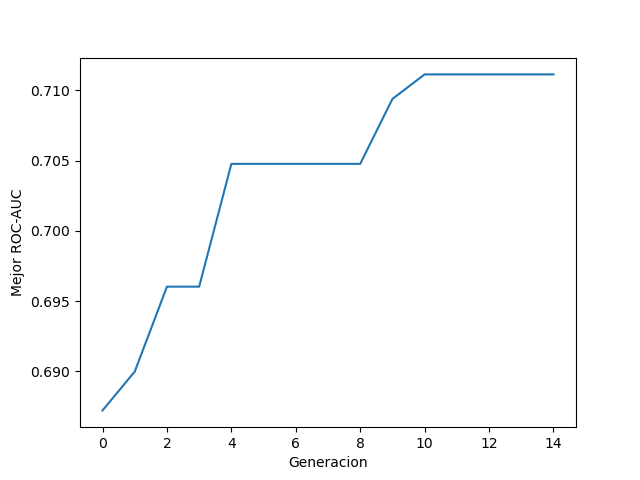

Wall time: 2min 54s


In [16]:
%%time
### Ejecucion del Algoritmo Genetico

### Hiperparametros
num_samples = X_train_under_z.shape[0]
num_feature_elements = X_train_under_z.shape[1]

num_generations = 15#50   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)

data_inputs, data_outputs = X_z.values, Y.values

### Correr el algoritmo genético
best_solution, best_solution_indices, best_solution_num_elements, best_solution_fitness = GA.genetic_algorithm(X_train,num_generations, sol_per_pop, porc_mutation, porc_genes,
                                                                                                              num_feature_elements,data_inputs, data_outputs, 
                                                                                                              train_indices, test_indices, classifier, num_mutations,num_genes)


In [17]:
### Las variables obtenidas son
vars_obt = []
for i in range(len(best_solution)):
    if best_solution[i]==1:
        vars_obt.append(X.columns[i])

### Evaluacion del modelo con las variables obtenidas
clf_AG = XGBClassifier(n_estimators = 300, 
                          max_depth = 2,
                          random_state = 42)

clf_AG.fit(X_train_under_z[vars_obt], Y_train_under)

### Metricas en validation

preds_val = clf_AG.predict_proba(X_val_z[vars_obt])
ROC_val_AG = roc_auc_score(Y_val,preds_val[:,1])
        
print(f'Se seleccionaron {len(vars_obt)} variables, se obtuvo un ROC-AUC de {ROC_val_AG} en Validacion\n')
print(vars_obt)

Se seleccionaron 51 variables, se obtuvo un ROC-AUC de 0.7220280850006214 en Validacion

['precipProbability', 'temperature', 'humidity', 'cloudCover', 'visibility', 'hora_1', 'hora_3', 'hora_4', 'hora_7', 'hora_8', 'hora_9', 'hora_10', 'hora_13', 'hora_14', 'hora_16', 'hora_17', 'hora_18', 'hora_19', 'hora_21', 'hora_22', 'icon_cloudy', 'icon_fog', 'icon_rain', 'dia_sem_3', 'dia_sem_4', 'dia_sem_6', 'Mes_Junio', 'Year_2017', 'apparentTemperature_mean', 'cloudCover_mean', 'humidity_mean', 'temperature_mean', 'visibility_mean', 'dewPoint_mean_forward', 'precipIntensity_mean_forward', 'windSpeed_mean_forward', 'cumAcc_7D', 'cumAcc_14D', 'cumAcc_60D', 'poblado_alejandria', 'poblado_barriocolombia', 'poblado_castropol', 'poblado_eldiamanteno2', 'poblado_laaguacatala', 'poblado_lalinde', 'poblado_laslomasno1', 'poblado_laslomasno2', 'poblado_losbalsosno2', 'poblado_patiobonito', 'poblado_sanlucas', 'poblado_santamariadelosangeles']


# Guardamos los resultados obtenidos

En un archivo JSON guardamos los resultados de los 3 metodos

In [18]:
Resultados = {'lasso':{'num_features':len(vars_lasso),
                       'roc_val': ROC_val_lasso,
                       'features':list(vars_lasso)},
              'forward':{'num_features':len(var_relevant),
                       'roc_val': ROC_val_forward,
                       'features':var_relevant},
              'AG':{'num_features':len(vars_obt),
                    'roc_val': ROC_val_AG,
                    'features':vars_obt}
              }


with open(f'{base_path}/models/{version}/analisis_var_relevantes.json','w') as json_file:
    json.dump(Resultados, json_file)